In [45]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch

sc.settings.verbosity = 3


In [46]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [47]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read Data

In [49]:
from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [50]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata = sc.read_h5ad(adata_path)

In [51]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)
    

In [52]:
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
#                'Stroma Vimentin+': 'Stroma'
#               }
rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


# Analysis COL neighborhood

In [53]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [54]:
from skimage.measure import block_reduce
from skimage import filters 

def mean_block(img, size):
    reduced = block_reduce(img_col, block_size=(size, size), func=np.mean)
    # reduced = filters.gaussian(reduced, sigma=1)
    img_mean = np.repeat(reduced, size, axis=0)
    img_mean = np.repeat(img_mean, size, axis=1)
    img_mean[:img.shape[0], :img.shape[1]]
    img_mean = filters.gaussian(img_mean, sigma=10)
    return reduced, img_mean 

In [55]:
from skimage import morphology
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_gradient(mask, size=100, n=5):
    mask = morphology.remove_small_objects(mask, min_size=10000)
    mask_grad = (mask*1).astype(np.uint8)    
    for i in range(2, n+2):
        mask_expanded = expand_labels(mask_grad, distance=size)
        mask_expanded = np.where(mask_expanded>0, mask_expanded+1, 0) 
        mask_grad = np.where(mask_grad>0, mask_grad, mask_expanded) 
    return mask_grad

In [56]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//4:, -1] = np.linspace(0.0,1.0, ncolors-ncolors//4)

# create a colormap object
mycmap_y= LinearSegmentedColormap.from_list(name='mycmap_y', colors=color_array)


(5000, 4000)


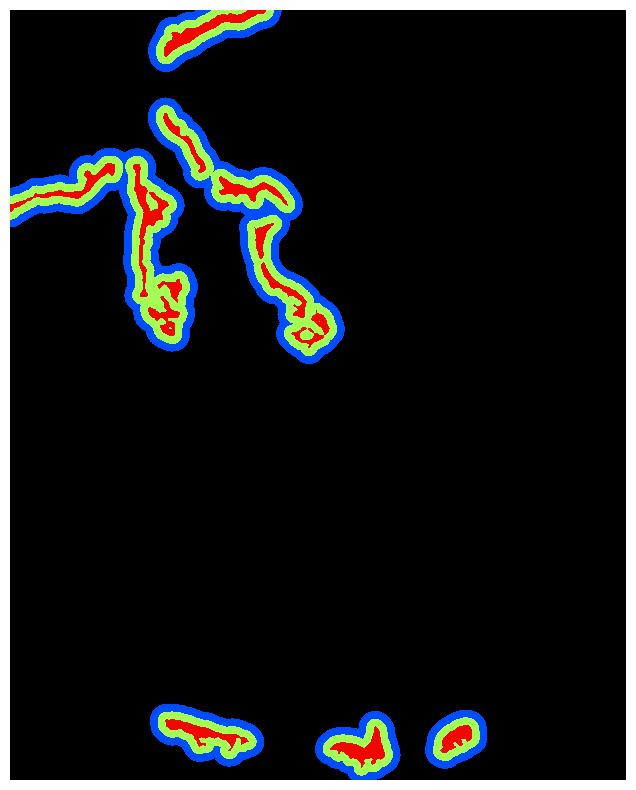

(2000, 9000)


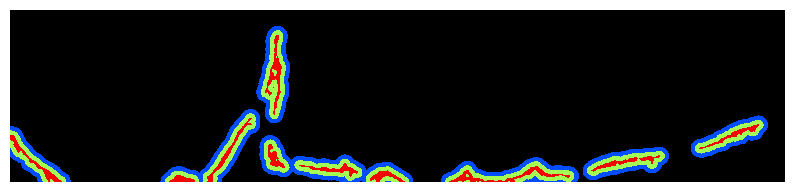

(5000, 4000)


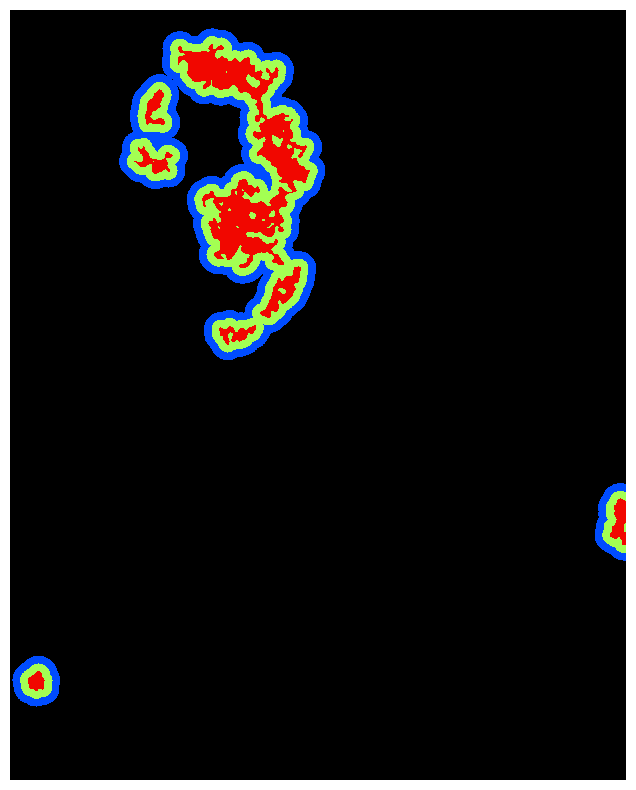

(5000, 5000)


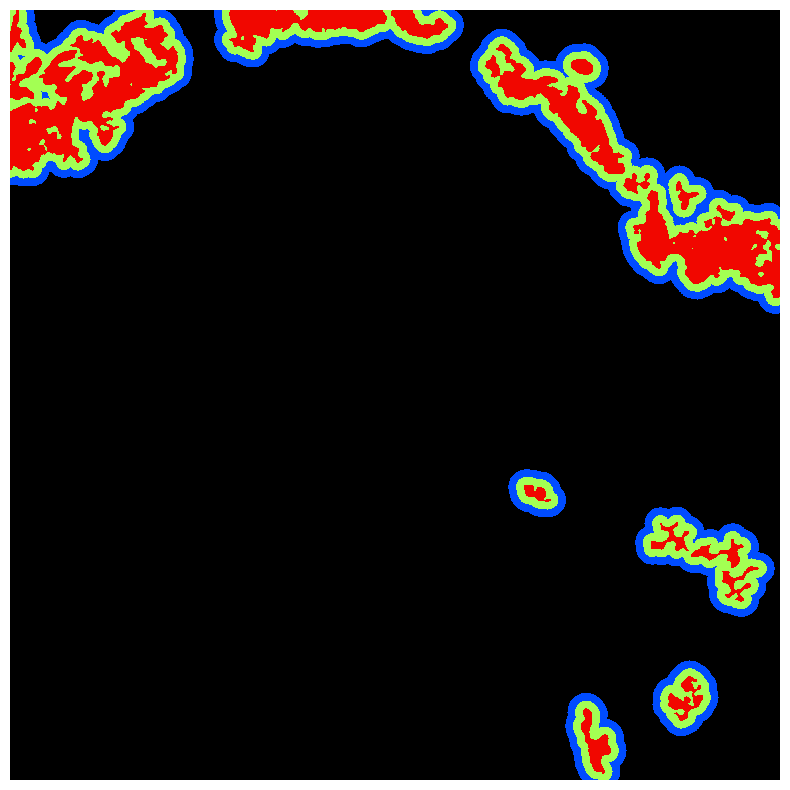

(2000, 7000)


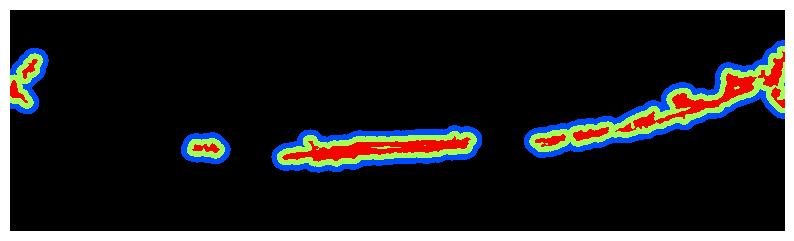

(6000, 3000)


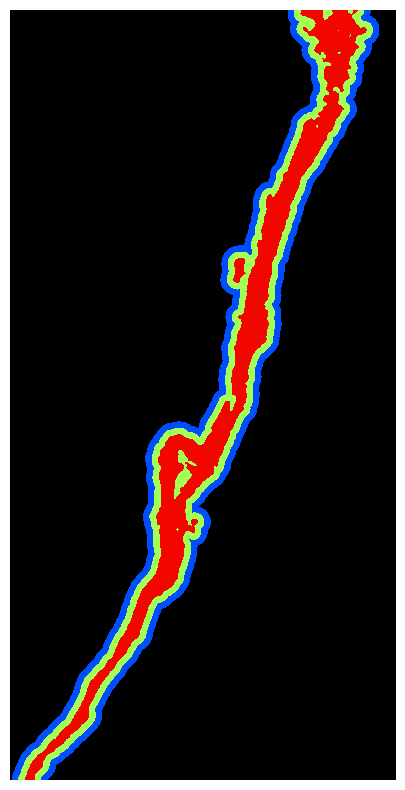

In [57]:
size = 20
thresh = 60
masks_grad = []
n = 2
pad_size = 50

# get colormap
ncolors = n+1
color_array = plt.get_cmap('jet_r')(np.linspace(0.1, 0.8, ncolors))

# change alpha values
color_array = np.vstack([np.array([0,0,0,1]), color_array])

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)

for i in range(len(donors)):
    # Read COL image and follicle mask
    img_col = imgs_col[i]
    print(img_col.shape)
    
    # Get average marker image
    _, img_mean = mean_block(img_col, size)
    img_mean_pos = img_mean > thresh
    
    # Get Gradient image
    mask_grad = create_gradient(img_mean_pos, size=pad_size, n=n)
    masks_grad.append(mask_grad)
    
    # fig, ax = plt.subplots(figsize=(10,10))
    # ax.imshow(img_mean)
    # ax.axis('off')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mask_grad, cmap=mycmap, interpolation='none')
    ax.axis('off')
    
    plt.show()


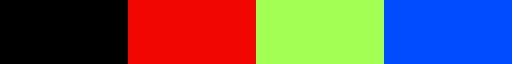

In [58]:
# create a colormap object
ListedColormap(colors=color_array)

In [59]:
# for i in range(len(donors)):
#     # Read COL image and follicle mask
#     img_col = imgs_col[i]
#     print(img_col.shape)
    
#     fig, ax = plt.subplots(figsize=(10,10), facecolor='k')
#     ax.imshow(img_col, cmap=mycmap_y, alpha=1) 

#     ax.axis("off")

In [60]:
dfs_pheno = []
for i in range(len(donors)):
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X = np.array(adata_donor.obsm['spatial'])[:,[1,0]].astype(int)
    df_pheno = pd.DataFrame(adata_donor.obs.cluster)
    mask_grad = masks_grad[i]
    zones = mask_grad[X[:,0], X[:,1]]
    df_pheno['Zone'] = zones
    df_pheno['Donor'] = donors[i]
    dfs_pheno.append(df_pheno)

In [61]:
df_pheno = pd.concat(dfs_pheno)

In [62]:
df_count = df_pheno.groupby(['Donor', 'Zone'])[['cluster']].value_counts()
df_count = df_count.reset_index()
df_count.columns = ['Donor', 'Zone', 'cluster', 'Count']
df_count = df_count[df_count.Zone != 0]

In [63]:
df_count

Donor  Zone                cluster  Count
13   INT Donor B     1                 Stroma   1759
14   INT Donor B     1                B-cells    465
15   INT Donor B     1             DZ B-cells    389
16   INT Donor B     1                  Other    163
17   INT Donor B     1                    TFH    148
..           ...   ...                    ...    ...
307   TS Donor E     3                   Treg    134
308   TS Donor E     3                    FDC     73
309   TS Donor E     3  myeloid-derived cells     48
310   TS Donor E     3      Exhausted T-cells      4
311   TS Donor E     3                  Other      2

[234 rows x 4 columns]

In [64]:
df_pivot = df_count.pivot(index=['Zone', 'Donor'], columns='cluster', values='Count') + 1
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [65]:
df_pivot

cluster            B-cells     CD38+  Cytotoxic T-cells  DZ B-cells  \
Zone Donor                                                            
1    INT Donor B  0.135308  0.014518           0.036005    0.113240   
     INT Donor E  0.195427  0.001611           0.039470    0.005329   
     LN Donor A   0.040915  0.018724           0.001387    0.006241   
     LN Donor E   0.056157  0.015243           0.006418    0.003209   
     TS Donor A   0.061743  0.023066           0.012582    0.005126   
     TS Donor E   0.010864  0.035441           0.003028    0.000712   
2    INT Donor B  0.146419  0.015759           0.059844    0.108518   
     INT Donor E  0.198363  0.004766           0.062404    0.069598   
     LN Donor A   0.189378  0.027137           0.023928    0.007587   
     LN Donor E   0.293220  0.011247           0.115681    0.015746   
     TS Donor A   0.092182  0.037746           0.117832    0.028898   
     TS Donor E   0.030134  0.212680           0.071975    0.014835   
3    INT Donor B  0.146750  0.019433           0.066786    0.107661   
     INT Donor E  0.139434  0.004558           0.077022    0.082048   
     LN Donor A   0.180074  0.026288           0.037066    0.015773   
     LN Donor E   0.311739  0.014674           0.089239    0.023264   
     TS Donor A   0.059612  0.017620           0.154463    0.084934   
     TS Donor E   0.034030  0.111027           0.128042    0.074090   

cluster           Exhausted T-cells       FDC  Helper T-cells  LZ B-cells  \
Zone Donor                                                                  
1    INT Donor B           0.000871  0.000290        0.039199    0.016841   
     INT Donor E           0.001115  0.000186        0.018712    0.007497   
     LN Donor A            0.000693  0.007628        0.002774    0.005548   
     LN Donor E            0.000401  0.000401        0.009627    0.001203   
     TS Donor A            0.000233  0.000466        0.016309    0.000466   
     TS Donor E            0.000178  0.000356        0.005699    0.000178   
2    INT Donor B           0.001197  0.000399        0.044484    0.065230   
     INT Donor E           0.002158  0.000360        0.027246    0.045859   
     LN Donor A            0.000292  0.015174        0.014882    0.075576   
     LN Donor E            0.000161  0.000321        0.056877    0.038882   
     TS Donor A            0.000224  0.000560        0.152106    0.009857   
     TS Donor E            0.000116  0.001159        0.128999    0.002782   
3    INT Donor B           0.001564  0.002010        0.054277    0.092919   
     INT Donor E           0.002454  0.001753        0.035180    0.126461   
     LN Donor A            0.000526  0.013407        0.021293    0.169295   
     LN Donor E            0.000239  0.002147        0.056311    0.210809   
     TS Donor A            0.000633  0.001583        0.248892    0.025322   
     TS Donor E            0.000538  0.007969        0.353866    0.033707   

cluster              Other    Stroma       TFH      Treg  \
Zone Donor                                                 
1    INT Donor B  0.047619  0.511034  0.043264  0.027584   
     INT Donor E  0.004275  0.364892  0.311791  0.046161   
     LN Donor A   0.002774  0.866158  0.002774  0.010402   
     LN Donor E   0.000401  0.882070  0.006418  0.013638   
     TS Donor A   0.000233  0.618826  0.005359  0.253029   
     TS Donor E   0.000178  0.918077  0.001069  0.022796   
2    INT Donor B  0.055855  0.343706  0.096948  0.041692   
     INT Donor E  0.040104  0.380631  0.132362  0.029584   
     LN Donor A   0.011380  0.479136  0.035600  0.012547   
     LN Donor E   0.003695  0.344312  0.030206  0.057359   
     TS Donor A   0.000448  0.271841  0.036066  0.247200   
     TS Donor E   0.000232  0.496291  0.004868  0.023644   
3    INT Donor B  0.032611  0.284566  0.132231  0.036408   
     INT Donor E  0.056802  0.274427  0.141071  0.041725   
     LN Donor A   0.010778  0.335962  0.073081  0.031020   
     LN Donor E   

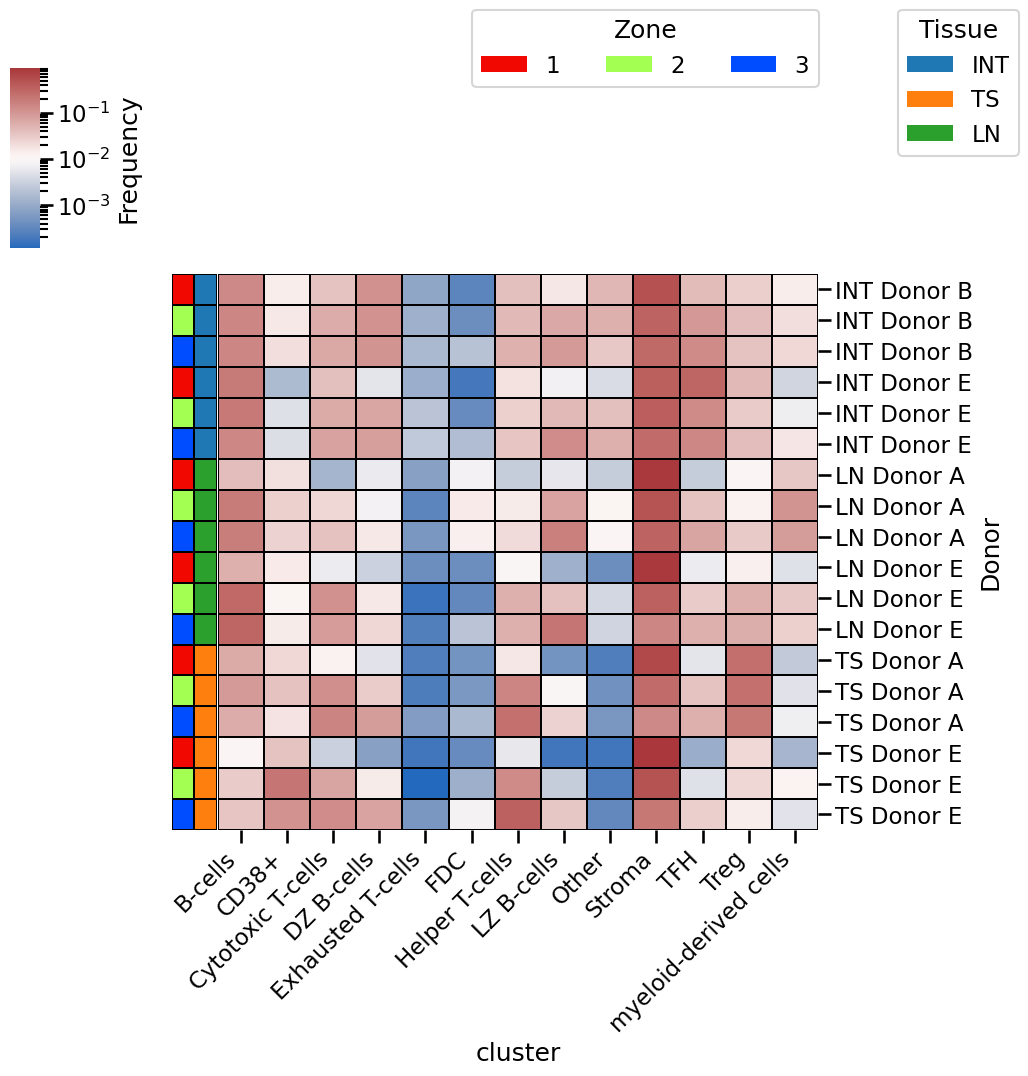

In [66]:
df = df_pivot.sort_index(level=1)

with sns.plotting_context('talk', font_scale=1):
    # Row colors 1
    labels = df.index.get_level_values(0).tolist()
    lut = dict(zip(set(labels), color_array[1:]))
    row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)
    
    # Row colors2
    labels2 = df.index.get_level_values(1).tolist()
    labels2 = [w.split(' ')[0] for w in labels2]
    lut2 = dict(zip(set(labels2), sns.color_palette("tab10")[:len(set(labels2))]))
    row_colors2 = pd.DataFrame(labels2, columns=[' '])[' '].map(lut2)
    
    # Clustermap
    kws = dict(cbar_kws=dict(label='Frequency'))

    g = sns.clustermap(df.droplevel(0, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
                            cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors, row_colors2], linecolor='k', norm=LogNorm(),
                           **kws)
    
    # Legend row colors 1
    handles = [Patch(facecolor=lut[name]) for name in lut.keys()]
    l1 = plt.legend(handles, lut, title='Zone', ncol=5,
               bbox_to_anchor=(0.8, 1.15), bbox_transform=plt.gcf().transFigure, loc='upper right')
    
    # Legend row colors 2
    handles2 = [Patch(facecolor=lut2[name]) for name in lut2.keys()]
    l2 = plt.legend(handles2, lut2, title='Tissue',
               bbox_to_anchor=(1.0, 1.15), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.gca().add_artist(l1)
    
#     x0, _y0, _w, _h = g.cbar_pos
#     g.ax_cbar.set_position([x0, 0.9, g.ax_row_dendrogram.get_position().width, 0.02])
#     g.ax_cbar.set_title('colorbar title')
#     g.ax_cbar.tick_params(axis='x', length=10)
    
    # Rotation x axis
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Comparison of zonation with only 1 donor

In [67]:
donors

['LN Donor A',
 'LN Donor E',
 'INT Donor B',
 'INT Donor E',
 'TS Donor A',
 'TS Donor E']

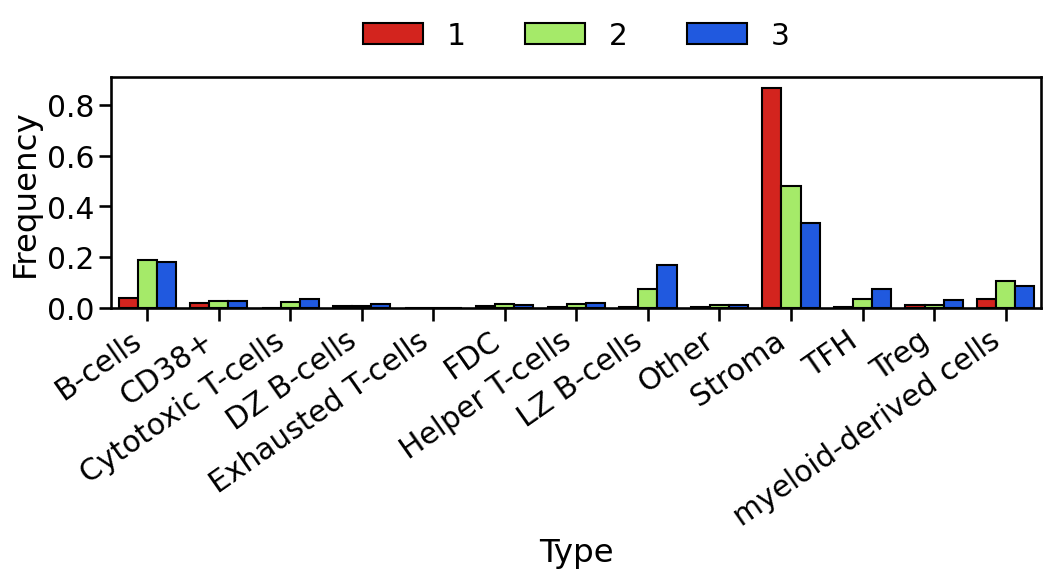

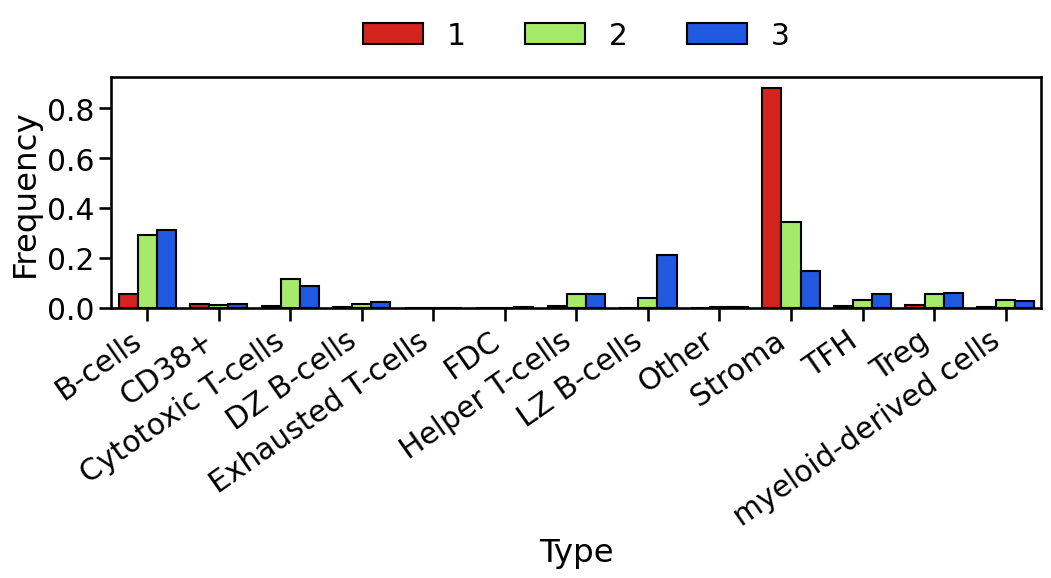

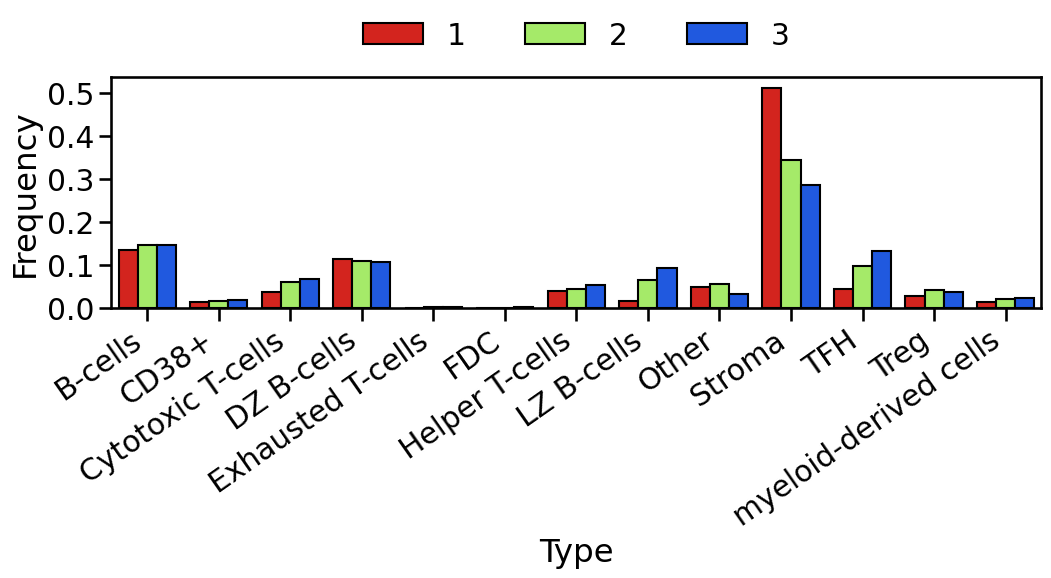

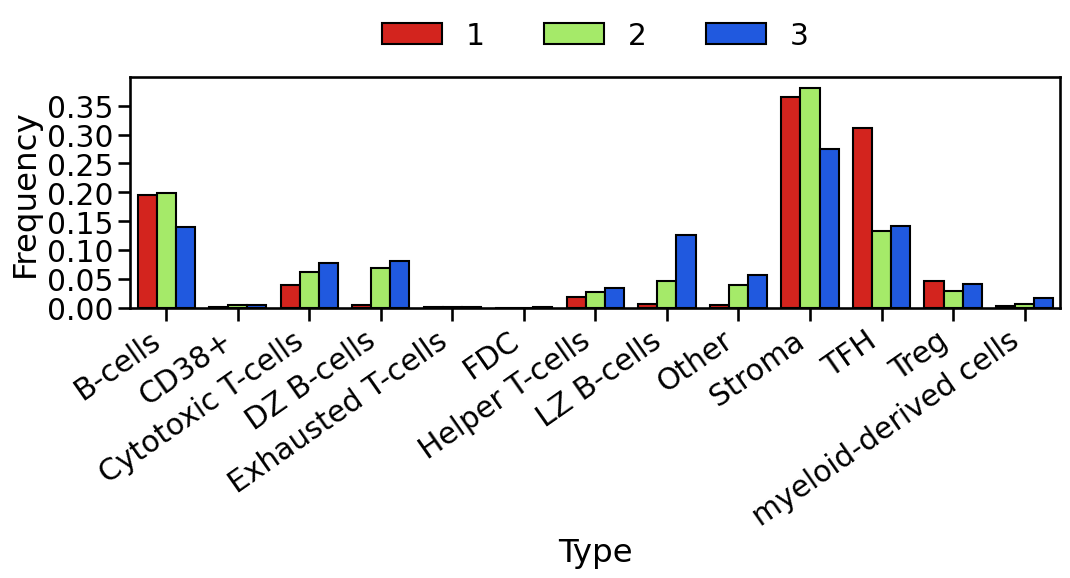

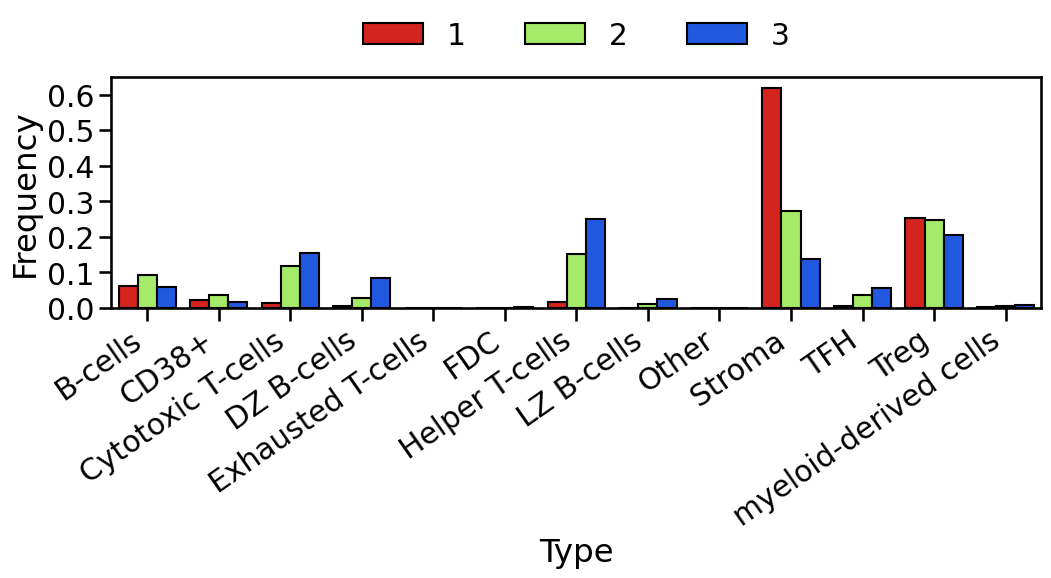

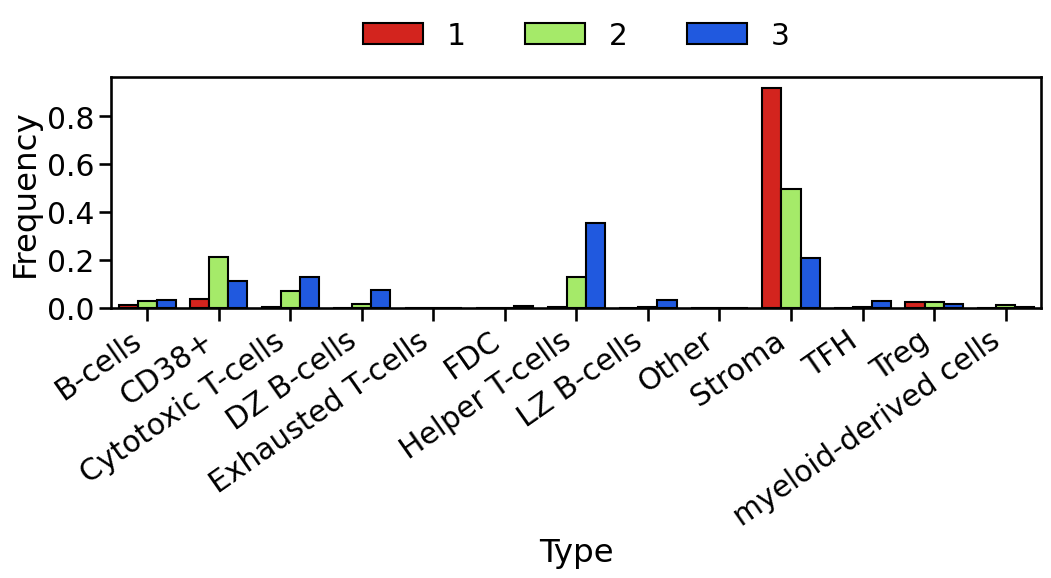

In [68]:
# Only one dataset
markers = ['B-cells', 'DZ B-cells','FDC', 'Helper T-cells', 'LZ B-cells', 'Stroma', 'TFH']

for donor in donors:
    df_subset = df_pivot.loc[df_pivot.index.get_level_values(1) == donor, :]
    
#     df = df_subset
#     with sns.plotting_context('talk', font_scale=1.5):
#         # Row colors 1
#         labels = df.index.get_level_values(0).tolist()
#         lut = dict(zip(set(labels), color_array[1:]))
#         row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)

#         # Clustermap
#         kws = dict(cbar_kws=dict(label='Frequency'))

#         g = sns.clustermap(df.droplevel(1, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
#                                 cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors], linecolor='k', norm=LogNorm(), figsize=(14,8),
#                                **kws)
#         # Rotation x axis
#         plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
#         plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, ha='left')
        
    # Barplot
    df_subset = (df_subset.reset_index()
     .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
    )

    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        g = sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        plt.xticks(rotation=35, ha='right')

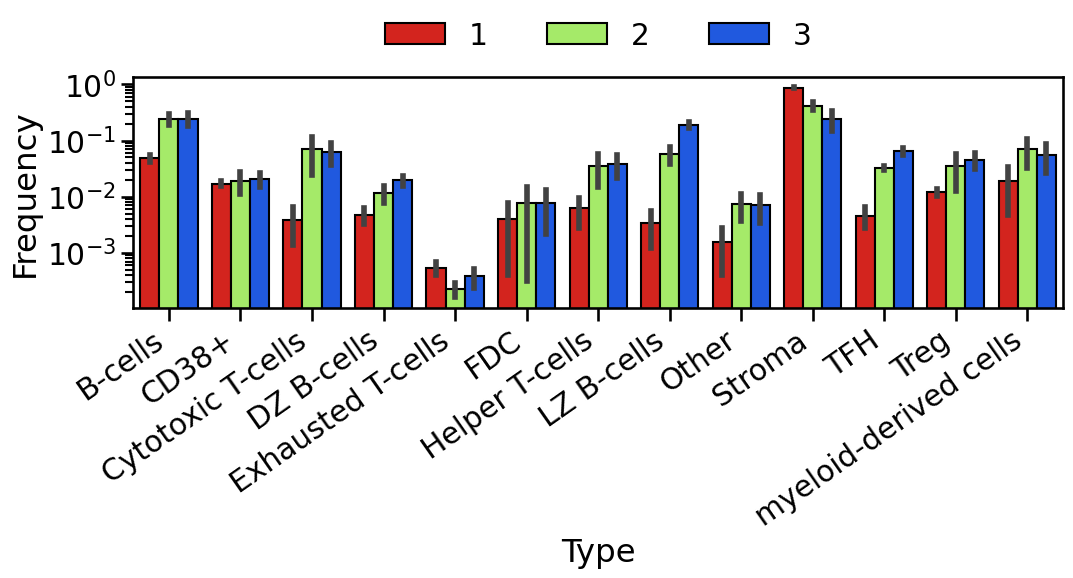

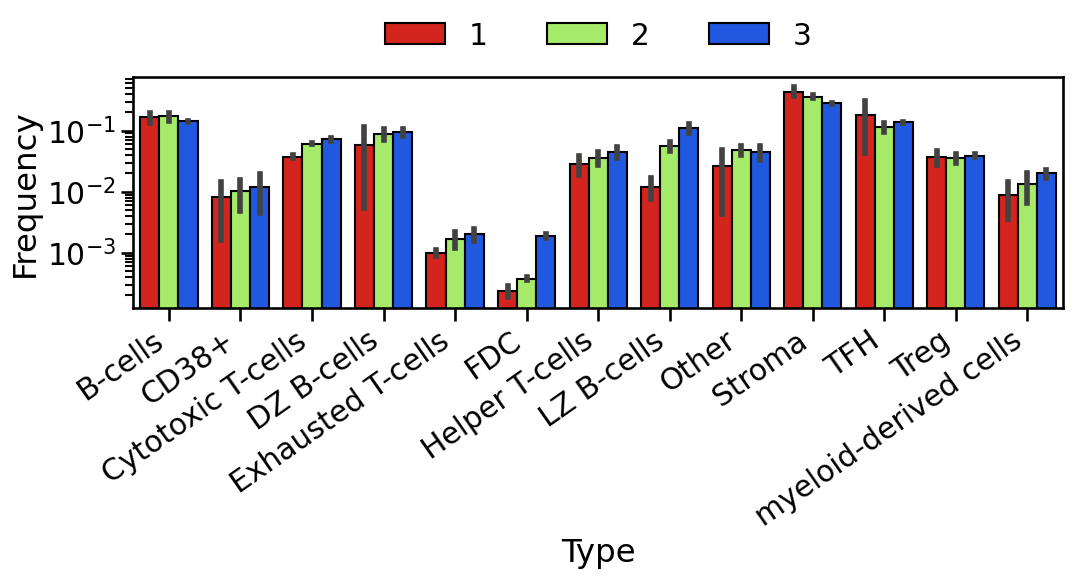

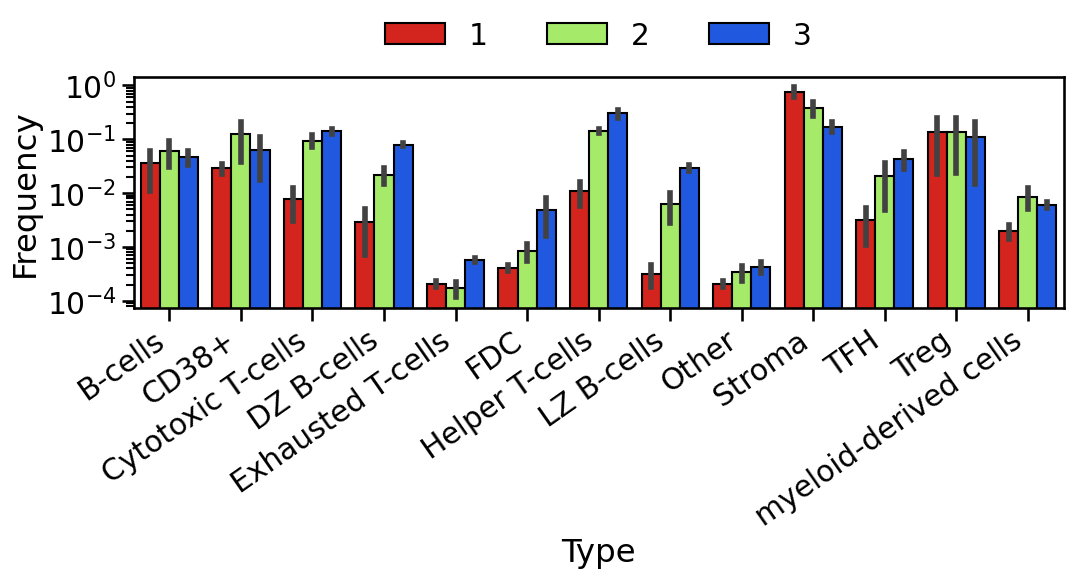

In [73]:
tissues = [['LN Donor A',
 'LN Donor E'],
 ['INT Donor B',
 'INT Donor E'],
 ['TS Donor A',
 'TS Donor E']]

for tissue in tissues:
    df_subset = df_pivot.loc[df_pivot.index.get_level_values(1).isin(tissue), :]
    
    # Barplot
    df_subset = (df_subset.reset_index()
     .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
    )

    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        g = sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        g.set_yscale("log")
        plt.xticks(rotation=35, ha='right')

In [70]:
# df = df_pivot.loc[df_pivot.index.get_level_values(1) == donor, markers]

# with sns.plotting_context('talk', font_scale=1.5):
#     # Row colors 1
#     labels = df.index.get_level_values(0).tolist()
#     lut = dict(zip(set(labels), color_array[1:]))
#     row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)

    
#     # Clustermap
#     kws = dict(cbar_kws=dict(label='Frequency'))

#     g = sns.clustermap(df.droplevel(1, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
#                             cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors], linecolor='k', norm=LogNorm(), figsize=(14,8),
#                            **kws)
    

#     # Rotation x axis
#     plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
#     plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, ha='left')

In [71]:
# df_subset = (df.reset_index()
#  .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
# )

# with sns.plotting_context('talk', font_scale=1.3):
#     fig,ax = plt.subplots(figsize=(12,3))
#     sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
#                edgecolor='k', width=0.9)
#     sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
#     plt.xticks(rotation=35, ha='right')

# Plot clustered cell in mask

In [37]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [38]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1


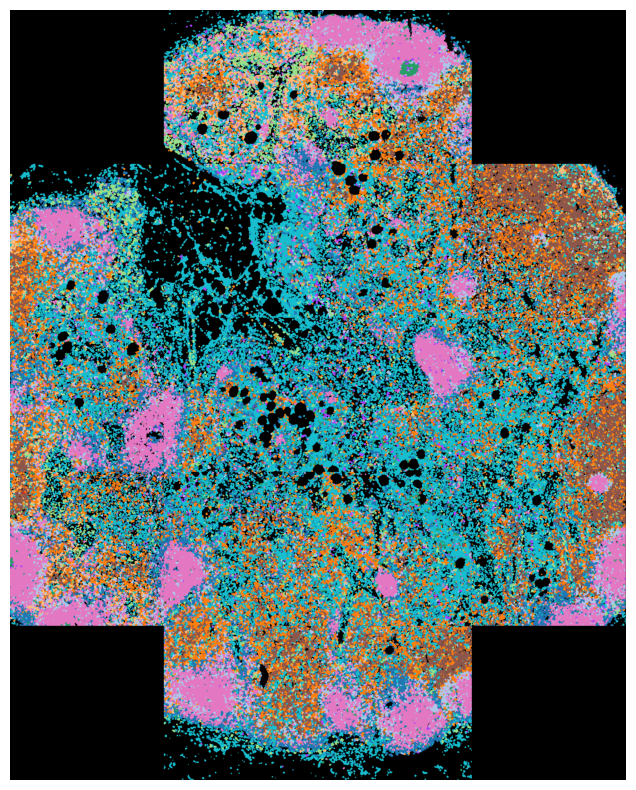

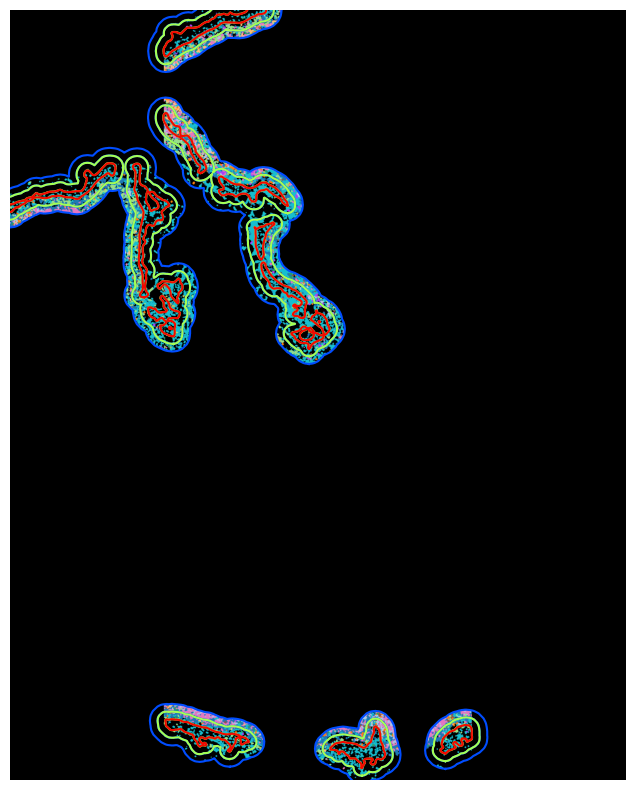

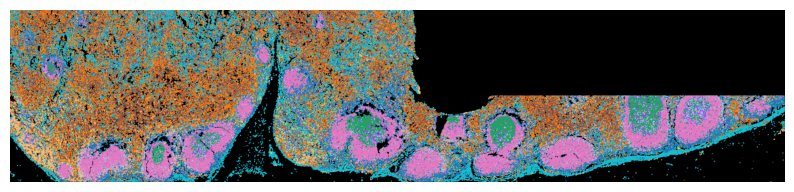

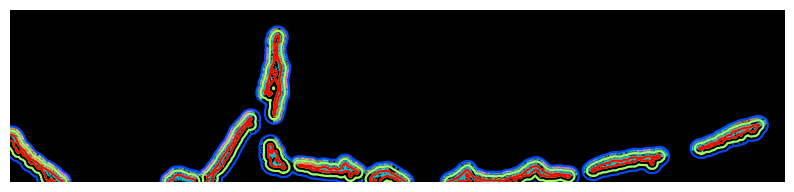

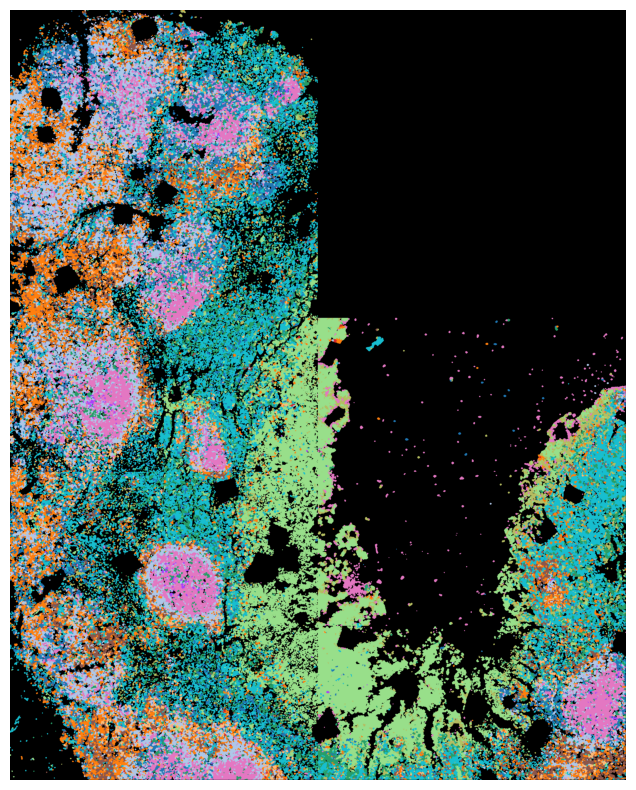

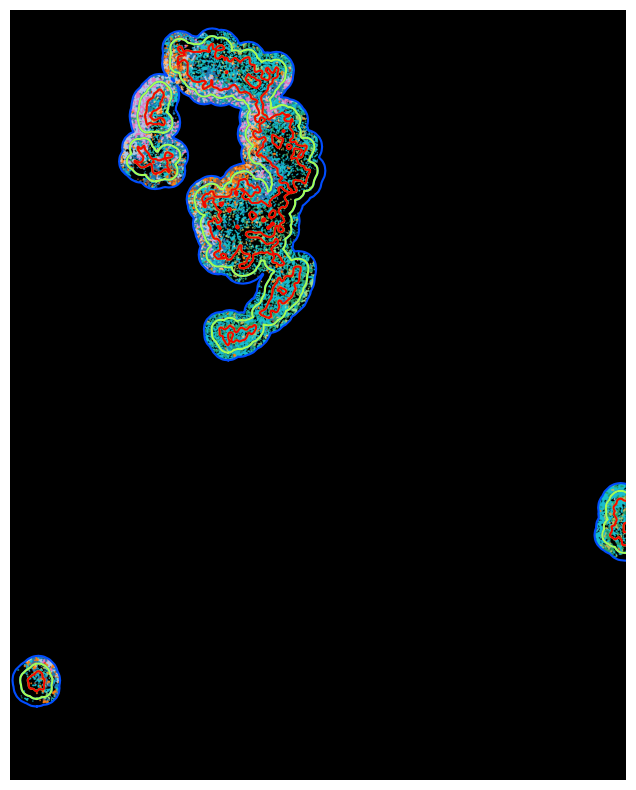

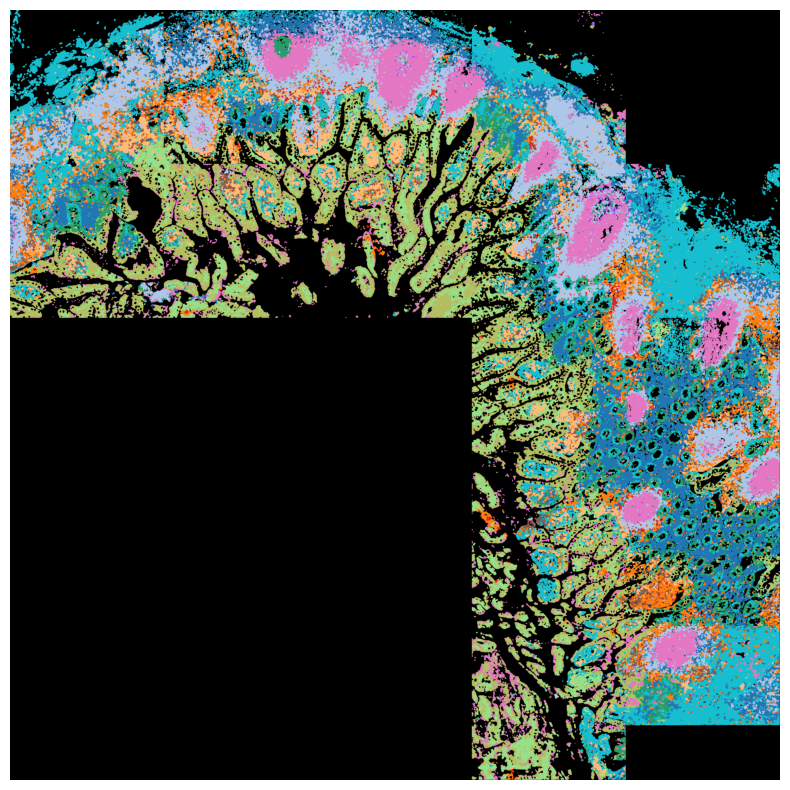

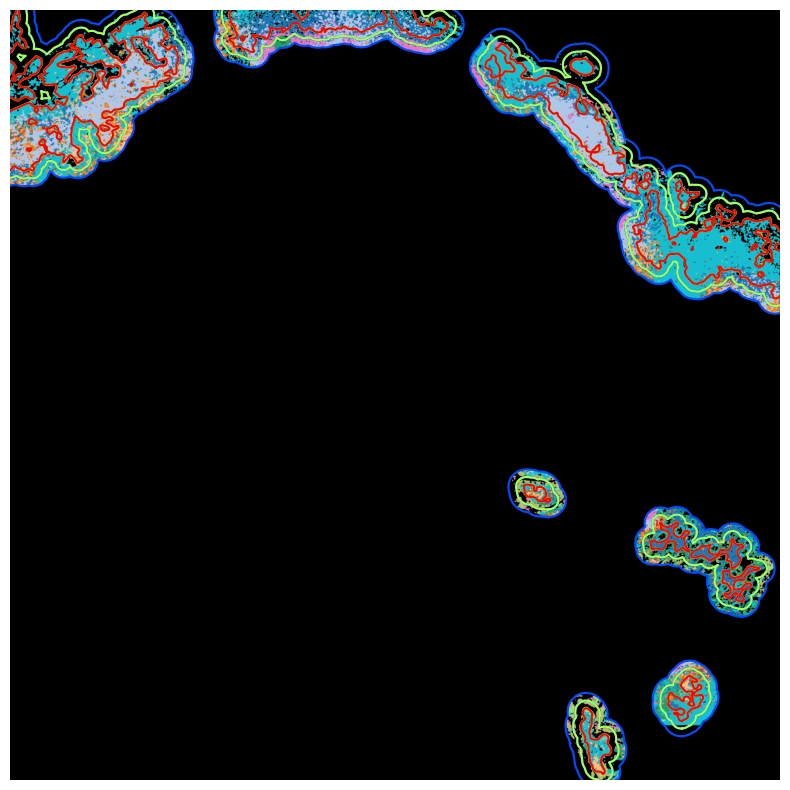

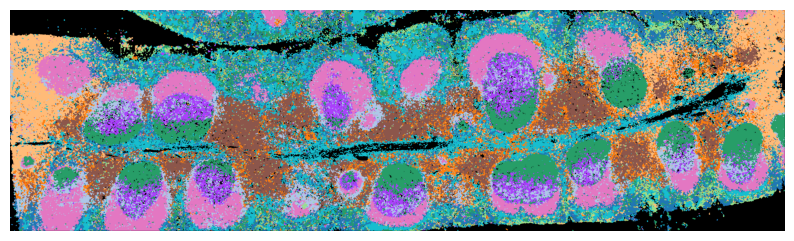

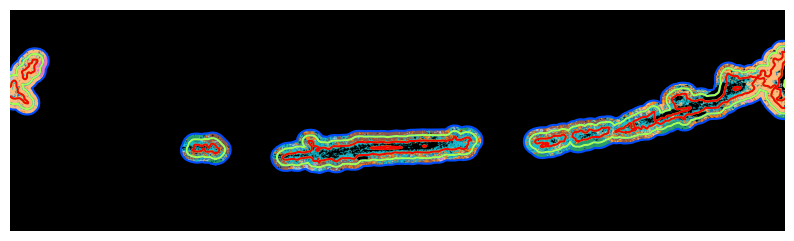

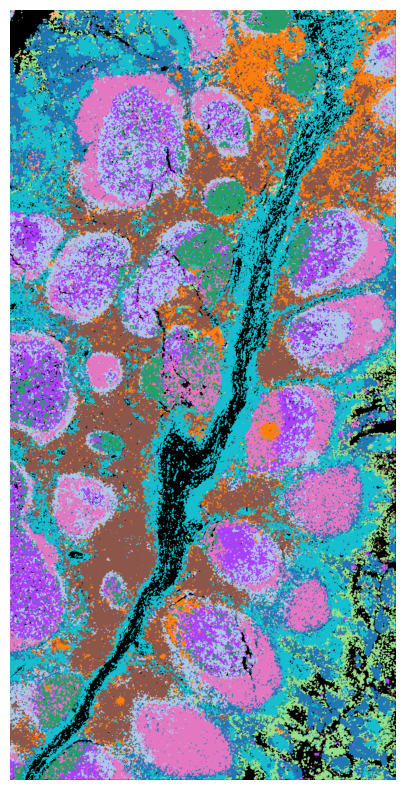

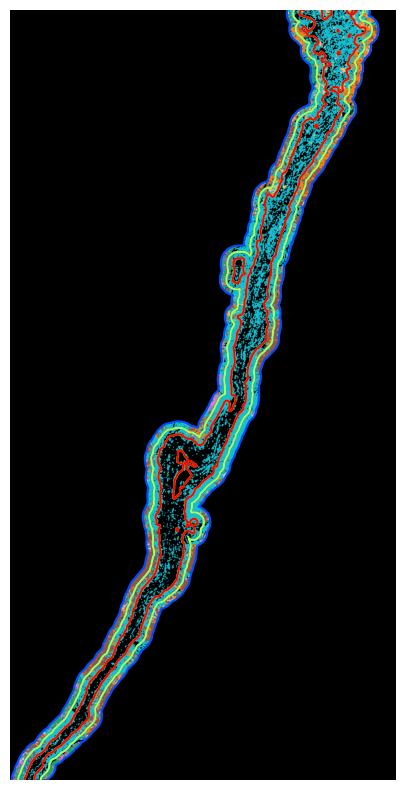

In [40]:
for donor in donors:
# Get mask
    masks = get_masks(data_dir / "masks" / donor)

    # Get adata 
    phenotype_name = 'cluster'

    sc.tl.dendrogram(adata, groupby=phenotype_name)

    adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
    cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

    # Define colormap
    colors = adata.uns["New_colors"]
    labels = adata.obs[phenotype_name].cat.categories.tolist()

    colors_rgb = []
    for color in colors:
        colors_rgb.append(matplotlib.colors.hex2color(color))
    colors_rgb = np.array(colors_rgb) * 255
    colors_rgb = colors_rgb.astype(np.uint8)
    colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}
    
    size = 1000 
    adata_donor = adata[adata.obs.Dataset == donor, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    mask_grad = masks_grad[donors.index(donor)]

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_combined)
    ax.axis('off')
    
    mask_temp = mask_grad > 0
    mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(np.where(mask_temp>0, img_combined,0))
    ax.axis('off')

    for zone in np.unique(mask_grad)[::-1][:-1]:
        print(zone)
        # Get zone mask
        mask_temp = mask_grad == zone

        # Get follicle contours
        contours = measure.find_contours(mask_temp, 0.8)
        # contours, hierarchy = cv2.findContours(mask_temp.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Pot contours
        for j, contour in enumerate(contours):
            contour = contour.squeeze()
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=color_array[zone], linestyle='-')


In [32]:
size = 1000 
adata_donor = adata[adata.obs.Dataset == donor, :]

# Create combined images
y_max, x_max = get_img_size(arrangement[donor])
img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

mask_grad = masks_grad[donors.index(donor)]

for i in adata_donor.obs.ROI.unique():
    if i not in arrangement[donor].keys():
        continue

    # Get dataset
    adata_s = adata_donor[adata_donor.obs.ROI == i, :]
    mask = masks[str(int(i))]

    # Get label2cell dict
    label2cell = {}
    for j, l in enumerate(labels):
        cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
        label2cell[j] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    # Insert to combine image
    y = max(0, arrangement[donor][i][0] - 1)
    x = max(0, arrangement[donor][i][1] - 1)
    img_combined[y : y + size, x : x + size] = img

(-0.5, 2999.5, 5999.5, -0.5)

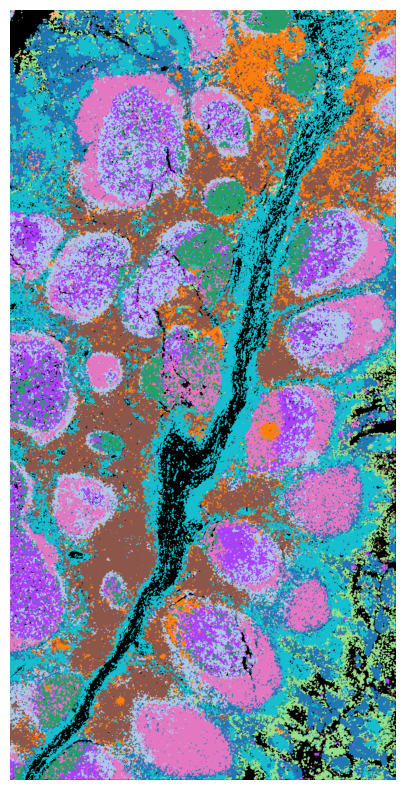

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_combined)
ax.axis('off')

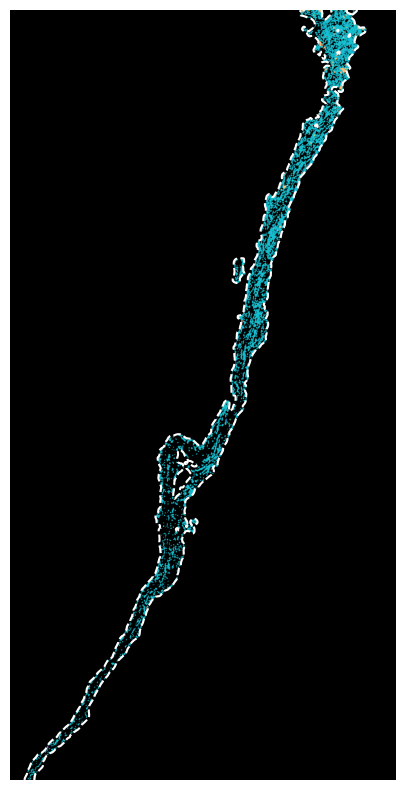

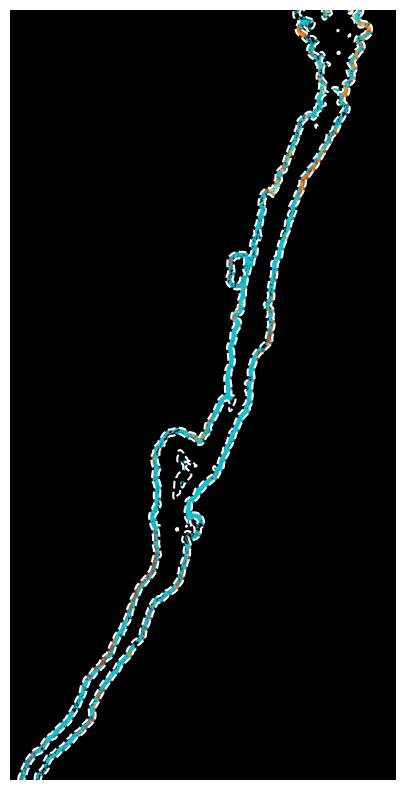

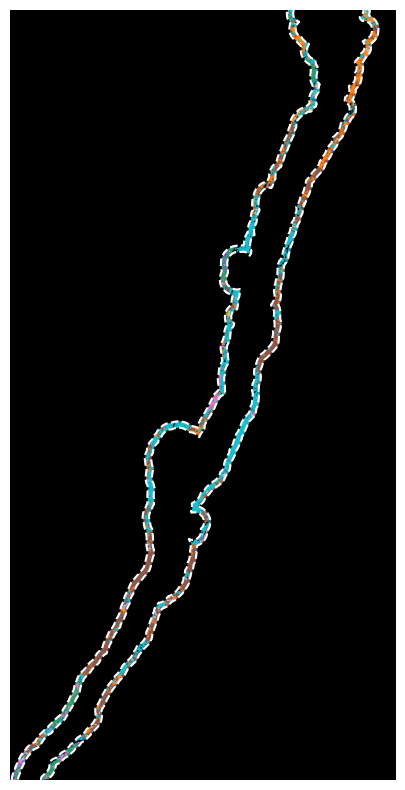

In [34]:
for zone in np.unique(mask_grad)[1:]:
    # Get zone mask
    mask_temp = mask_grad == zone
    
    # Get follicle contours
    contours = measure.find_contours(mask_temp, 0.8)
    
    # Plot images
    mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(np.where(mask_temp>0, img_combined,0))
    ax.axis('off')
    for j, contour in enumerate(contours):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color="white", linestyle='dashed')

3
2
1


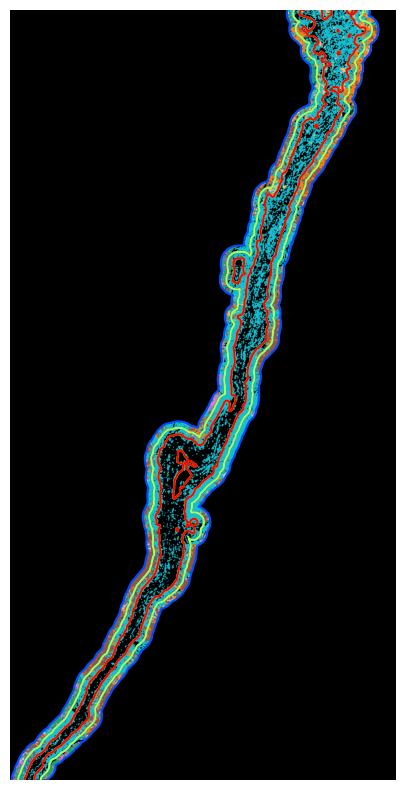

In [ ]:
mask_temp = mask_grad > 0
mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)
    
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.where(mask_temp>0, img_combined,0))
ax.axis('off')

for zone in np.unique(mask_grad)[::-1][:-1]:
    print(zone)
    # Get zone mask
    mask_temp = mask_grad == zone
    
    # Get follicle contours
    contours = measure.find_contours(mask_temp, 0.8)
    # contours, hierarchy = cv2.findContours(mask_temp.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Pot contours
    for j, contour in enumerate(contours):
        contour = contour.squeeze()
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=color_array[zone], linestyle='-')
